In [2]:
# Importing necessary libraries from PyTorch and TorchVision
from torchvision import datasets, transforms  # For image dataset and preprocessing transforms
from torch.utils.data import DataLoader, random_split  # For loading data and splitting datasets

# Defining the sequence of image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all images to 224x224 pixels (ConvNeXt input requirement)
    transforms.ToTensor(),  # Convert image to PyTorch tensor and scale pixel values to [0.0, 1.0]
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
    # Normalize each channel (R, G, B) to have mean=0 and std=1 for more stable training
])

# Defining the path to image dataset on pc
DATASET_PATH = "C:/Users/iwadi/Downloads/BreaKHis_v1/histology_slides/breast"

# Loading the entire dataset using ImageFolder
full_dataset = datasets.ImageFolder(root=DATASET_PATH, transform=transform)

# Spliting the dataset: 70% training, 15% validation, 15% testing
train_size = int(0.7 * len(full_dataset))  # Compute number of training samples
val_size = int(0.15 * len(full_dataset))   # Compute number of validation samples
test_size = len(full_dataset) - train_size - val_size  # Remaining goes to testing

# Randomly spliting the dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

In [3]:
# Creating data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)

print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")

Train: 5536 | Val: 1186 | Test: 1187


In [4]:
import torch.nn as nn
import torch.nn.functional as F

# ✅ SE Attention Module
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(channels, channels // reduction, bias=False)
        self.fc2 = nn.Linear(channels // reduction, channels, bias=False)

    def forward(self, x):
        b, c, _, _ = x.size()
        y = F.adaptive_avg_pool2d(x, 1).view(b, c)
        y = F.relu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y)).view(b, c, 1, 1)
        return x * y

In [5]:
from torchvision.models import convnext_base, ConvNeXt_Base_Weights

# ✅ ConvNeXt model with SE injection
class ConvNeXtWithSE(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.features = base_model.features
        self.avgpool = base_model.avgpool
        self.classifier = base_model.classifier

        # Inject SE block after each CNBlock group
        for i, stage in enumerate(self.features):
            if isinstance(stage, nn.Sequential):
                for j, block in enumerate(stage):
                    if hasattr(block, 'block'):
                        channels = block.block[0].in_channels
                        block.block = nn.Sequential(
                            block.block,
                            SEBlock(channels)
                        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.classifier(x)
        return x

In [6]:
import torch

# ✅ Load pretrained ConvNeXt Base
weights = ConvNeXt_Base_Weights.IMAGENET1K_V1
base_model = convnext_base(weights=weights)

# ✅ Wrap with SE-enhanced version
model = ConvNeXtWithSE(base_model)

# ✅ Modify classifier for binary classification
model.classifier[2] = nn.Linear(model.classifier[2].in_features, 2)

# ✅ Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print("✅ ConvNeXt + SE model is ready on", device)

✅ ConvNeXt + SE model is ready on cpu


In [7]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import os
import time
import psutil

# ✅ Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)

# ✅ Tracking
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

num_epochs = 5
checkpoint_path = f"convnext_se_epoch{num_epochs}.pth"

# ✅ Check if training already completed
if os.path.exists(checkpoint_path):
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.to(device)
    print(f"✅ Model already trained. Loaded from {checkpoint_path}")
    skip_training = True
else:
    print("⚠️ No final model found. Training will begin.")
    skip_training = False
    start_epoch = 1

# ✅ Only train if not already completed
if not skip_training:
    for epoch in range(start_epoch, num_epochs + 1):
        start_time = time.time()

        model.train()
        train_loss, train_correct = 0, 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} [Train]"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_correct += (outputs.argmax(1) == labels).sum().item()

        avg_train_loss = train_loss / len(train_loader)
        avg_train_acc = train_correct / len(train_loader.dataset)

        # 🔁 Validation
        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch}/{num_epochs} [Val]"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_correct += (outputs.argmax(1) == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        avg_val_acc = val_correct / len(val_loader.dataset)

        # 🔁 Log + Save
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(avg_train_acc)
        val_accuracies.append(avg_val_acc)
        scheduler.step(avg_val_loss)

        print(f"\n✅ Epoch {epoch}")
        print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {avg_train_acc:.4f}")
        print(f"Val   Loss: {avg_val_loss:.4f} | Val   Acc: {avg_val_acc:.4f}")
        print("-" * 60)

        # ✅ Save model
        torch.save(model.state_dict(), f"convnext_se_epoch{epoch}.pth")
        print(f"✅ Model saved: convnext_se_epoch{epoch}.pth")

        # ✅ Time & memory
        elapsed = time.time() - start_time
        print(f"⏱️ Time taken: {elapsed:.2f} seconds")
        mem = psutil.virtual_memory()
        print(f"🧠 RAM Used: {(mem.total - mem.available) / 1024**3:.2f} GB")
        if torch.cuda.is_available():
            print(f"🚀 GPU Used: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
            print(f"💾 GPU Cached: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")


✅ Model already trained. Loaded from convnext_se_epoch5.pth



📊 Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      0.99      0.99       407
   Malignant       1.00      1.00      1.00       780

    accuracy                           1.00      1187
   macro avg       1.00      1.00      1.00      1187
weighted avg       1.00      1.00      1.00      1187



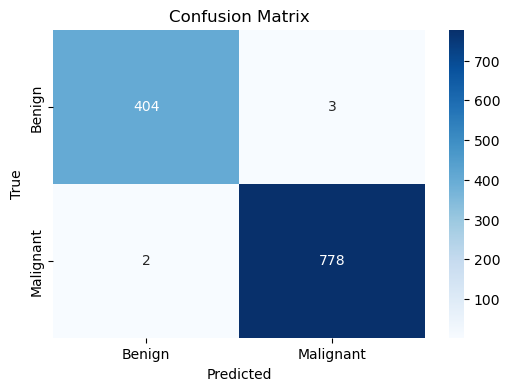

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ✅ Print classification report
print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=["Benign", "Malignant"]))

# ✅ Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Benign", "Malignant"], yticklabels=["Benign", "Malignant"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [9]:
# Manually reconstructed training/validation data (example values based on your previous outputs)
train_losses = [0.2124, 0.0824, 0.0503, 0.0536, 0.0386]
val_losses = [0.1556, 0.1334, 0.0526, 0.0506, 0.0324]

train_accuracies = [0.9207, 0.9718, 0.9821, 0.9821, 0.9854]
val_accuracies = [0.9325, 0.9477, 0.9806, 0.9823, 0.9899]


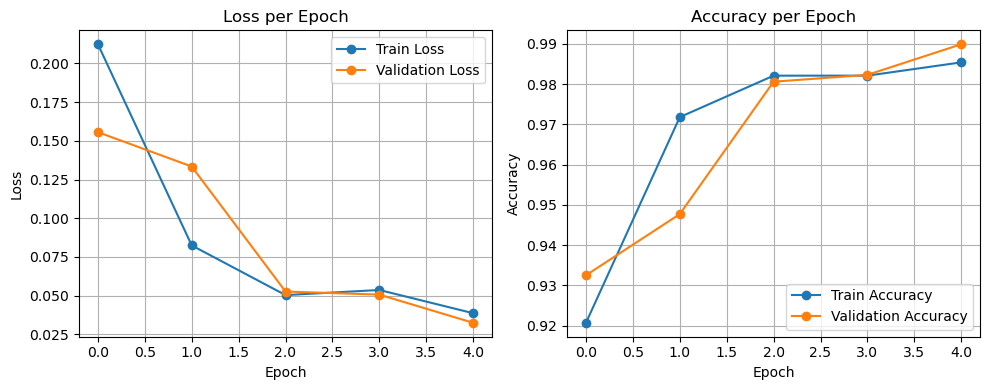

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

# 🔻 Loss Curve
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# 🔺 Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(val_accuracies, label='Validation Accuracy', marker='o')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [11]:
!pip install grad-cam

In [12]:
from pytorch_grad_cam import GradCAM


In [13]:
# === GRAD-CAM VISUALIZATION FOR ATTENTION MAP ===
import os
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Helper function to unnormalize tensor image
def tensor_to_numpy_image(tensor):
    image = tensor.squeeze().detach().cpu()
    image = image.permute(1, 2, 0).numpy()
    image = image * [0.5, 0.5, 0.5] + [0.5, 0.5, 0.5]  # reverse normalization
    return np.clip(image, 0, 1)

# Create folder to save attention maps
os.makedirs("gradcam_outputs", exist_ok=True)

# Choose N samples to visualize
model.eval()
cam = GradCAM(model=model, target_layers=[model.features[-1][0].block[0]])

samples_to_visualize = 6
count = 0

class_names = ['Benign', 'Malignant']

for images, labels in test_loader:
    for i in range(images.size(0)):
        if count >= samples_to_visualize:
            break

        img_tensor = images[i].unsqueeze(0).to(device)
        label = labels[i].item()
        np_img = tensor_to_numpy_image(img_tensor)

        # Preprocess
        input_tensor = preprocess_image(np_img.astype(np.float32), mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]).to(device)

        # Forward pass to get prediction
        model.eval()
        with torch.no_grad():
            output = model(img_tensor)
            pred_class = torch.argmax(output, dim=1).item()

        # Grad-CAM
        grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(label)])[0]
        visualization = show_cam_on_image(np_img.astype(np.float32), grayscale_cam, use_rgb=True)

        # Save with labels in filename
        fname = f"gradcam_outputs/heatmap_{count+1}_true_{class_names[label]}_pred_{class_names[pred_class]}.jpg"
        cv2.imwrite(fname, cv2.cvtColor(visualization, cv2.COLOR_RGB2BGR))
        print(f"✅ Saved: {fname}")
        count += 1
    if count >= samples_to_visualize:
        break

✅ Saved: gradcam_outputs/heatmap_1_true_Malignant_pred_Malignant.jpg
✅ Saved: gradcam_outputs/heatmap_2_true_Benign_pred_Benign.jpg
✅ Saved: gradcam_outputs/heatmap_3_true_Malignant_pred_Malignant.jpg
✅ Saved: gradcam_outputs/heatmap_4_true_Malignant_pred_Malignant.jpg
✅ Saved: gradcam_outputs/heatmap_5_true_Malignant_pred_Malignant.jpg
✅ Saved: gradcam_outputs/heatmap_6_true_Malignant_pred_Malignant.jpg
